<a href="https://colab.research.google.com/github/kriaz100/deep-learning-with-python-notebooks/blob/master/chapter05_fundamentals-of-ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Fundamentals of machine learning

## Generalization: The goal of machine learning

### Underfitting and overfitting

#### Noisy training data

#### Ambiguous features

#### Rare features and spurious correlations
ML models trained on rare features are suseptible to overfitting.

- If you have seen only two orange tabby cats who were terribly antisocial, you may infer that orange tabby cats were antisocial. It would take more exposure to tabby cats for you to learn that color is unrelated to cat character.

- If a sentiment classification model was trained a reviws that included a review containing a rare word 'chrimoya', and the review happened to be negative, the model is likely to classify review containing 'cherimoya' as representing negative sentiment. 

- Spurrious correlation is not limited to cases that occur only a couple of times. If a word occurs 100 times, and is associated with positive sentiment 54% of the time, the model is likely to leverage that feature. This is overfitting becuase the proportion of occurance (54%) may be a just statistical fluke.

Below we perform the following expriments:

        (a) Concatenate to the 784 features of original MNIST training data, an additional 784 features of random noise (784 columns of random numbers)   -- so that half of teh data is white noise. 
        (b) concatenate 784 zero columns or features to the original 784 MNIST training data features   

**Adding white-noise channels or all-zeros channels to MNIST**

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)   # axis =1 means column concatenation

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

**Training the same model on MNIST data with noise channels or all-zero channels**

We will run the model twice: onece with noise cannels and once with zero channels, and compare the performance

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# defining NN architecture and compiling the model
def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# Training the model on data with NOISE channels  
model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

# Training the model on data with ZEROS
model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

**Plotting a validation accuracy comparison**

Plotting validation accuracy when model is trainied on data with NOISE vs when it is trained on data with ZEROS

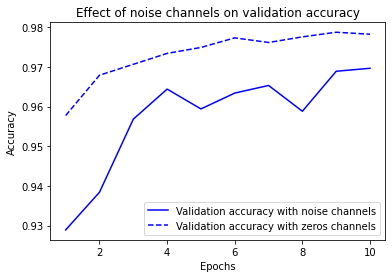

In [3]:
import matplotlib.pyplot as plt
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

Validation accuracy of model trained on NOISE channels is 1 percent point lower than the validation accuracy of data with zeros.

- Noisy features inevitably lead to overfitting
- Feature selection is a good strategy for dealing with overfitting. You may select features based on some usefulness score of features.


### The nature of generalization in deep learning

The model's ability to generalize is assessed on unseen data (e.g validation loss). The training loss would continue to decline even if the classification labels of the target variable were randomly assigned. This is demonstrated below.

**Fitting a MNIST model with randomly shuffled labels**

In [ ]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]  # select all labels
np.random.shuffle(random_train_labels) # reshuffle the labels. Now they dont match original inputs.

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, random_train_labels,
          epochs=100,
          batch_size=128,
          validation_split=0.2)

The training loss declined continuously from 2.3 to 0.46 but the validation loss did not decline. Instead it rose to 7.72

#### The manifold hypothesis

The MNIST data are 28 x 28 arrays. The pixel actually corresponding to the handwritten digits are a *sub-space* of this space. 

Within the space of 28x28 arrays, the hand written digits are a *manifold* -- a lower dimensional *subspace* of some parent space that is locally similar to a linear (ie Euclidian) space. A smooth curve is a 1D manifold in 2D space (i.e. the plane). The curve is continuous and connected. It can be approximated as a series of tangents (to the curve itself).

The curve can morph into different shapes, and there is a series of intermediate shapes. Likewise the handwritten digits are continuous and connected subspaces. Two handwritten digits (A & B) have a sequence of intermediate shapes that morph A into B (see fig 5.7). Another example is the digits on an electronic calculator.

The manifold hypothesis implies that:
- Machine learning models only have to fit relatively simple, low dimensional, highly structured subspaces within their potential input space (latent manifolds)

- Within one of these manifolds, it is alsways possible to *interpolate* between two inputs, that is to say, morph one into another via a continuous path along which all points fall on a manifold.

<font color ='blue'>The ability to interpolate between samples is the key to understanding generalization in deep learning</font>


#### Interpolation as a source of generalization

- You can make sense of **totality** of a space by using only a **sample** of the space by interpolating to fill the blanks.
- Interpolation enables only a local generalization. Model can make sense of things very close to what it has seen before.
-By contrast, humans are capable of *extreme generlization* because of other cognitive abilities that we call to reasoning (inlcuding abstraction, symbolic models of the world, reasoning, logic, common sense, and innate priors about the world), as opposed to interpolative abilities (intuition or pattern recognition). 

#### Why deep learning works
- A flattened *paper-ball* is a 2D *manifold* wihin a 3D space
- A deep learning model is a tool for uncrumpling (flatening) paper-balls, that is, for disentagling latent manifolds. The model is basically a high-dimensional curve.
- The curve involves enogh parameters to fit anything. But given the fact that your datapoints are not randomly sprinkled in the subspace but form a highly structiured subspace (manifold hypothesis), there will be an intermediate point during training at which the model roughly approximates the natural manifold of the data.
- If the approximtion is good, moving along the curve would be moving along the latent manifold of data. 
- As such the model will be capable of making sense of never-seen-before inputs via interpolation between trainiung inputs. 

#### Training data is paramount
Deep learning is well suited to manifold learning but the power to generalize depends on input data forming a manifold where the points can be interpolated. The generalization will depend on the following:

- Informativeness of features and there being less noise in them. Data curation and feature engineering are essential.

- Denseness of sampling from the input space, especially near the deciion boundary. This would make external knowledge unnecessary.

- More *and* better data. Adding noisy data does not help as already noted.

- Regularization i.e. modulating the quantity of information stored by the model, especially when getting more data is not possible. Controlling how much the model can memorize will force it to focus on the most important features. More on regularization in sec 5.4.4.


## Evaluating machine-learning models
Evaluating the model means reliably measuring its generalization power.

- You train your model on training data, evaluate it on validation data, and test it one final time on a test dataset as similar as possible to the production data.



### Training, validation, and test sets
Why do we use validation data instead of evaluating the model directly on test data?

- Because evaluting the model always involves hyperparameter tuning where you search for a good configuration (eg number of layers and size of layers).
- Hyperparameter tuning is also a form of learning, and can lead to overfitting.
- Having validation data for hyperparameter tunning ensures that the final model evaluation is done on never-seen-before data (test data).
This prevents information leaks, especially when you run multiple experiments on your model (extensive hyperparameter tuning).

#### Simple hold-out validation
You set apart a fraction of data as test set, train on remaining data, and evaluate on test set. However, to prevent information leaks, youshold not tune the model on test data. Therefore, you should also reserve a validation set.

This may not be practicle if your data is too small. In that case you may have to use *K-fold validation* or *iterated K-fold valiadation*. 

 

#### K-fold validation
- Split your data into K partititions of equal size.
- For each partitition i, train a model on the remaining K-1 partititions, evaluate it on partition i.
-Your final evaluation score is the average of the K scores. 
- <font color='blue'> 
For a schematic representation of K-fold cross valiadtion see Fig 5.13 copied below</font> 

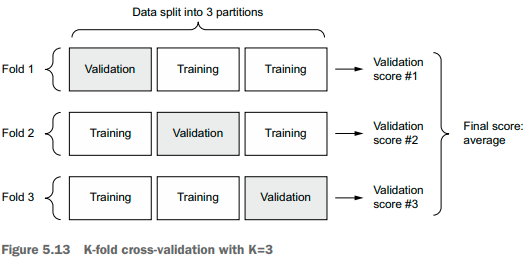

<font color='blue'>An outline of the code to perform K-fold cross validation is in Listing 5.5 in the book</font>

#### Iterated K-fold validation with shuffling
Used when relatively little data is available. <font color='blue'>Useful in Kaggle competitions</font>.
- Apply K-fold cross validation multiple  times, shuffling data every time before splitting it K ways. Final score is the average score in each run of tthe K-fold valiadation.  


### Beating a common-sense baseline
Try beating a trivial baseline on <font color='steel blue'>validation data</font>. For example:
- On MNIST data, accuracy greater than 0.1 (i.e.performanec of random classifier on 10 possible digits)
- If the data is imbalanced and 90% of samples belong to class A and 10% to B, then any classifier that always predicts class A will be accurate 90% of the time. Your model needs to beat that.

If the model cannot even beat the trivial baseline, it is worthless.

### Things to keep in mind about model evaluation
- *Data representativeness:* Randomly shuffle the data before splitting it.
- *The arrow of time:* However, do not shuffle timeseries data, it would cause a *temporal leak*. Your test data must be posterior to your training data.
- *Redundancy in your data:* Remove duplicates before shuffling and splitting the data. Otherwise copies of same observations(cases) would make their way into validation data. The training and validation data sets must be disjoint. 


## Improving model fit
*To achive the perfect fit, you must first overfit!*

Your objective is to get a model that achieves some generalization but overfits. After you have such a model you try to get greater generalization by reducing overfitting. 

At this stage, you will face three problems:
- Training loss does not decline ie training does not start.
- Model cannot generalize well ie you cannot beat the common-sense baseline
- You don't seem to be overfitting. Training and validation loss go down over time nad you beat the baseline but you are still underfitting.

We will see below how to address these issues: getting a model that has some generalization power (beats baseline) and is able to overfit.

### Tuning key gradient descent parameters


**Training a MNIST model with an incorrectly high learning rate**

In [ ]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1.),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

**The same model with a more appropriate learning rate**

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

### Leveraging better architecture priors

### Increasing model capacity

**A simple logistic regression on MNIST**

In [ ]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_small_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

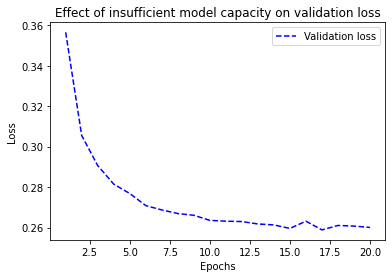

In [8]:
import matplotlib.pyplot as plt
val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [9]:
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax"),
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 3s 6ms/step - loss: 0.3560 - accuracy: 0.8992 - val_loss: 0.1774 - val_accuracy: 0.9486
Epoch 2/20
375/375 [==============================] - 2s 6ms/step - loss: 0.1571 - accuracy: 0.9537 - val_loss: 0.1345 - val_accuracy: 0.9594
Epoch 3/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1109 - accuracy: 0.9666 - val_loss: 0.1086 - val_accuracy: 0.9675
Epoch 4/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0836 - accuracy: 0.9744 - val_loss: 0.1023 - val_accuracy: 0.9696
Epoch 5/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0665 - accuracy: 0.9800 - val_loss: 0.1017 - val_accuracy: 0.9710
Epoch 6/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0551 - accuracy: 0.9837 - val_loss: 0.0888 - val_accuracy: 0.9743
Epoch 7/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0442 - accuracy: 0.9866 - val_loss: 0.0939 - val_accuracy: 0.9724
Epoch 

## Improving generalization

### Dataset curation

### Feature engineering

### Using early stopping

### Regularizing your model

#### Reducing the network's size

**Original model**

In [10]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)

17473536/17464789 [==============================] - 0s 0us/step
Epoch 1/20
30/30 [==============================] - 2s 45ms/step - loss: 0.5132 - accuracy: 0.7883 - val_loss: 0.3911 - val_accuracy: 0.8639
Epoch 2/20
30/30 [==============================] - 1s 32ms/step - loss: 0.3037 - accuracy: 0.9009 - val_loss: 0.3014 - val_accuracy: 0.8885
Epoch 3/20
30/30 [==============================] - 1s 33ms/step - loss: 0.2230 - accuracy: 0.9267 - val_loss: 0.2935 - val_accuracy: 0.8820
Epoch 4/20
30/30 [==============================] - 1s 32ms/step - loss: 0.1740 - accuracy: 0.9452 - val_loss: 0.2785 - val_accuracy: 0.8894
Epoch 5/20
30/30 [==============================] - 1s 31ms/step - loss: 0.1456 - accuracy: 0.9528 - val_loss: 0.3192 - val_accuracy: 0.8750
Epoch 6/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1192 - accuracy: 0.9637 - val_loss: 0.2957 - val_accuracy: 0.8853
Epoch 7/20
30/30 [==============================] - 1s 32ms/step - loss: 0.0996 - accurac

**Version of the model with lower capacity**

In [11]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_smaller_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 39ms/step - loss: 0.6414 - accuracy: 0.6593 - val_loss: 0.5948 - val_accuracy: 0.8257
Epoch 2/20
30/30 [==============================] - 1s 31ms/step - loss: 0.5507 - accuracy: 0.7943 - val_loss: 0.5398 - val_accuracy: 0.8267
Epoch 3/20
30/30 [==============================] - 1s 30ms/step - loss: 0.4998 - accuracy: 0.8426 - val_loss: 0.5108 - val_accuracy: 0.8197
Epoch 4/20
30/30 [==============================] - 1s 30ms/step - loss: 0.4632 - accuracy: 0.8745 - val_loss: 0.5006 - val_accuracy: 0.8080
Epoch 5/20
30/30 [==============================] - 1s 30ms/step - loss: 0.4351 - accuracy: 0.8964 - val_loss: 0.4760 - val_accuracy: 0.8749
Epoch 6/20
30/30 [==============================] - 1s 30ms/step - loss: 0.4117 - accuracy: 0.9171 - val_loss: 0.4657 - val_accuracy: 0.8775
Epoch 7/20
30/30 [==============================] - 1s 30ms/step - loss: 0.3919 - accuracy: 0.9307 - val_loss: 0.4577 - val_accuracy: 0.8785
Epoch 8/20
30

**Version of the model with higher capacity**

In [12]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_larger_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 10s 299ms/step - loss: 0.5491 - accuracy: 0.7637 - val_loss: 0.3161 - val_accuracy: 0.8842
Epoch 2/20
30/30 [==============================] - 8s 282ms/step - loss: 0.2426 - accuracy: 0.9079 - val_loss: 0.3365 - val_accuracy: 0.8636
Epoch 3/20
30/30 [==============================] - 8s 284ms/step - loss: 0.1515 - accuracy: 0.9429 - val_loss: 0.3210 - val_accuracy: 0.8833
Epoch 4/20
30/30 [==============================] - 8s 283ms/step - loss: 0.0810 - accuracy: 0.9735 - val_loss: 0.5304 - val_accuracy: 0.8530
Epoch 5/20
30/30 [==============================] - 8s 282ms/step - loss: 0.0443 - accuracy: 0.9904 - val_loss: 0.5548 - val_accuracy: 0.8348
Epoch 6/20
30/30 [==============================] - 8s 282ms/step - loss: 0.0057 - accuracy: 0.9996 - val_loss: 0.5310 - val_accuracy: 0.8866
Epoch 7/20
30/30 [==============================] - 8s 282ms/step - loss: 4.6827e-04 - accuracy: 1.0000 - val_loss: 0.6463 - val_accuracy: 0.8870
E

#### Adding weight regularization

**Adding L2 weight regularization to the model**

In [13]:
from tensorflow.keras import regularizers
model = keras.Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 43ms/step - loss: 0.6041 - accuracy: 0.7841 - val_loss: 0.4976 - val_accuracy: 0.8383
Epoch 2/20
30/30 [==============================] - 1s 33ms/step - loss: 0.4157 - accuracy: 0.8939 - val_loss: 0.3978 - val_accuracy: 0.8852
Epoch 3/20
30/30 [==============================] - 1s 34ms/step - loss: 0.3447 - accuracy: 0.9100 - val_loss: 0.3802 - val_accuracy: 0.8799
Epoch 4/20
30/30 [==============================] - 1s 38ms/step - loss: 0.3097 - accuracy: 0.9227 - val_loss: 0.3678 - val_accuracy: 0.8852
Epoch 5/20
30/30 [==============================] - 1s 33ms/step - loss: 0.2880 - accuracy: 0.9301 - val_loss: 0.3960 - val_accuracy: 0.8683
Epoch 6/20
30/30 [==============================] - 1s 32ms/step - loss: 0.2743 - accuracy: 0.9321 - val_loss: 0.3568 - val_accuracy: 0.8856
Epoch 7/20
30/30 [==============================] - 1s 34ms/step - loss: 0.2620 - accuracy: 0.9371 - val_loss: 0.3751 - val_accuracy: 0.8789
Epoch 8/20
30

**Different weight regularizers available in Keras**

In [14]:
from tensorflow.keras import regularizers
regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)

#### Adding dropout

**Adding dropout to the IMDB model**

In [15]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 41ms/step - loss: 0.6261 - accuracy: 0.6386 - val_loss: 0.5432 - val_accuracy: 0.8393
Epoch 2/20
30/30 [==============================] - 1s 32ms/step - loss: 0.5189 - accuracy: 0.7867 - val_loss: 0.4591 - val_accuracy: 0.8686
Epoch 3/20
30/30 [==============================] - 1s 35ms/step - loss: 0.4542 - accuracy: 0.8439 - val_loss: 0.4106 - val_accuracy: 0.8779
Epoch 4/20
30/30 [==============================] - 1s 42ms/step - loss: 0.4039 - accuracy: 0.8813 - val_loss: 0.3988 - val_accuracy: 0.8708
Epoch 5/20
30/30 [==============================] - 2s 51ms/step - loss: 0.3647 - accuracy: 0.9029 - val_loss: 0.3520 - val_accuracy: 0.8858
Epoch 6/20
30/30 [==============================] - 1s 50ms/step - loss: 0.3299 - accuracy: 0.9169 - val_loss: 0.3408 - val_accuracy: 0.8845
Epoch 7/20
30/30 [==============================] - 1s 33ms/step - loss: 0.3012 - accuracy: 0.9258 - val_loss: 0.3335 - val_accuracy: 0.8884
Epoch 8/20
30

## Summary